<a href="https://colab.research.google.com/github/AndresPerelmuter/Clustering/blob/main/Cluster_H%26M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se importan las librerias.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
transactions = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
articles = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/customers.csv")


In [50]:
transactions.head(10)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
5,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001,0.016932,2
6,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221001,0.020322,2
7,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,688873012,0.030492,1
8,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,501323011,0.053373,1
9,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,598859003,0.045746,2


In [51]:
transactions.shape

(31788324, 5)

In [52]:
transactions.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e-02,1.704028e+00
std,1.334480e+08,1.918113e-02,4.564786e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,6.328030e+08,1.581356e-02,1.000000e+00
50%,7.145820e+08,2.540678e-02,2.000000e+00
75%,7.865240e+08,3.388136e-02,2.000000e+00
max,9.562170e+08,5.915254e-01,2.000000e+00


In [53]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [54]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
#transactions['sales_channel_id'] = str((transactions['sales_channel_id']))
transactions['article_id'] = str((transactions['article_id']))

In [55]:
transactions.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                  object
price                      float64
sales_channel_id             int64
dtype: object

In [56]:
customers.head(10)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,NaN,NaN,ACTIVE,NONE,20.0,fe7b8e2b3fafb89ca90db17ffeeae0fd29b795d803f749...
7,00007d2de826758b65a93dd24ce629ed66842531df6699...,1.0,1.0,ACTIVE,Regularly,32.0,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,NaN,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...


In [57]:
customers.shape

(1371980, 7)

In [58]:
customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


In [59]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [60]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

In [61]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(customers)

Your selected dataframe has 7 columns and 1371980 Rows.
There are 5 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Active,0,907576,66.2,907576,66.2,float64
FN,0,895050,65.2,895050,65.2,float64
fashion_news_frequency,0,16009,1.2,16009,1.2,object
age,0,15861,1.2,15861,1.2,float64
club_member_status,0,6062,0.4,6062,0.4,object


In [62]:
#customers = customers.drop(['Active', 'FN'], axis=1)
customers = customers.dropna()

In [63]:
customers['age'] = pd.to_numeric(customers['age'], downcast="integer")
#customers['age'] = int(customers['age'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                          int8
postal_code                object
dtype: object

In [65]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                          int8
postal_code                object
dtype: object

In [66]:
articles.head(10)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
5,110065011,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,12,Light Beige,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
6,111565001,111565,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo..."
7,111565003,111565,20 den 1p Stockings,302,Socks,Socks & Tights,1010016,Solid,13,Beige,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo..."
8,111586001,111586,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Tights with built-in support to lift the botto...
9,111593001,111593,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny tights that shape the tummy, thighs..."


In [67]:
articles.shape

(105542, 25)

In [68]:
articles.describe()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,1.055420e+05,105542.000000,105542.000000,1.055420e+05,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000
mean,6.984246e+08,698424.563378,234.861875,1.009515e+06,32.233822,3.206183,7.807972,4532.777833,3.171534,42.664219,1010.438290
std,1.284624e+08,128462.384432,75.049308,2.241359e+04,28.086154,1.563839,5.376727,2712.692011,4.353234,23.260105,6.731023
min,1.087750e+08,108775.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1201.000000,1.000000,2.000000,1001.000000
25%,6.169925e+08,616992.500000,252.000000,1.010008e+06,9.000000,2.000000,4.000000,1676.000000,1.000000,20.000000,1005.000000
50%,7.022130e+08,702213.000000,259.000000,1.010016e+06,14.000000,4.000000,5.000000,4222.000000,2.000000,46.000000,1009.000000
75%,7.967030e+08,796703.000000,272.000000,1.010016e+06,52.000000,4.000000,11.000000,7389.000000,4.000000,61.000000,1017.000000
max,9.594610e+08,959461.000000,762.000000,1.010029e+06,93.000000,7.000000,20.000000,9989.000000,26.000000,97.000000,1025.000000


In [69]:
articles.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

In [70]:
min_fecha = min(transactions['t_dat'])
max_fecha = max(transactions['t_dat'])
print("Min Fecha:",min_fecha)
print("Max Fecha:",max_fecha)


Min Fecha: 2018-09-20 00:00:00
Max Fecha: 2020-09-22 00:00:00


In [71]:
df = transactions.groupby('customer_id').agg(
    precio_promedio=('price', 'mean'),
    compras_totales=('price', sum),
    cantidad_compras=('price', 'count'),
    # Get max of the duration column for each group
    fecha_ultima_compra=('t_dat', max),
    # Get min of the duration column for each group
    fecha_primer_compra=('t_dat', min),
    # Apply a lambda to date column
    antiguedad=("t_dat", lambda x: (max(x) - min(x)).days),   
)

In [72]:
df['promedio_dias_compra'] = transactions['previous_visit'] = transactions.groupby(['customer_id'])['t_dat'].shift()
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['t_dat'] - transactions['previous_visit']
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['days_bw_visits'].apply(lambda x: x.days)
df['promedio_dias_compra'] = transactions.groupby('customer_id')['days_bw_visits'].agg('mean')
#df['sales_channel_id'] = transactions.groupby(['customer_id'])['sales_channel_id'].agg(pd.Series.mode)
df = pd.merge(df, customers[['customer_id','age']], on="customer_id")
df.fillna(axis=1, method="bfill").fillna(0)


,customer_id,precio_promedio,compras_totales,cantidad_compras,fecha_ultima_compra,fecha_primer_compra,antiguedad,promedio_dias_compra,age
0,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.036130,0.469695,13,2020-08-12,2018-10-12,670,55.833333,52
1,00007d2de826758b65a93dd24ce629ed66842531df6699...,0.031863,3.823610,120,2020-05-13,2018-09-20,601,5.050420,32
2,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0.030911,5.007576,162,2020-08-30,2018-10-10,690,4.285714,56
3,0000ae1bbb25e04bdc7e35f718e852adfb3fbb72ef38b3...,0.024390,0.048780,2,2019-11-28,2019-11-28,0,0.000000,29
4,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,0.021609,0.864356,40,2020-08-29,2018-10-22,677,17.358974,54
...,...,...,...,...,...,...,...,...,...
459415,ffff7d65748db4d52e48b74c8f83ccb0029fc3bbafa511...,0.033034,0.066068,2,2019-10-20,2019-10-10,10,10.000000,20
459416,ffffa28cd7ab5d1cbbbfe7b582b1c419270cc0539f3dae...,0.029367,0.088102,3,2018-10-10,2018-10-10,0,0.000000,22
459417,ffffaff3905b803d1c7e153a1378a5151e1f34f236ba54...,0.122017,0.122017,1,2018-10-26,2018-10-26,0,21.000000,21
459418,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0.017532,0.788932,45,2020-09-09,2018-09-20,720,16.363636,21


In [83]:
df.fillna(0, inplace=True)

In [84]:
df['precio_promedio'] = df['precio_promedio'].astype(int)
df['compras_totales'] = df['compras_totales'].astype(int)
df['promedio_dias_compra'] = df['promedio_dias_compra'].astype(int)

In [85]:
df.dtypes

customer_id                     object
precio_promedio                  int64
compras_totales                  int64
cantidad_compras                 int64
fecha_ultima_compra     datetime64[ns]
fecha_primer_compra     datetime64[ns]
antiguedad                       int64
promedio_dias_compra             int64
age                               int8
dtype: object

In [86]:
dfcluster = df[["precio_promedio", "compras_totales", "cantidad_compras", "antiguedad", "promedio_dias_compra", "age"]]

In [33]:
df

,precio_promedio,compras_totales,cantidad_compras,fecha_ultima_compra,fecha_primer_compra,antiguedad,moda
customer_id,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0.030904,0.648983,21,2020-09-05,2018-12-27,618,2
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0.030255,2.601932,86,2020-07-08,2018-09-21,656,2
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.039154,0.704780,18,2020-09-15,2018-09-20,726,2
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.030492,0.060983,2,2019-06-09,2019-06-09,0,2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.036130,0.469695,13,2020-08-12,2018-10-12,670,2
...,...,...,...,...,...,...,...
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,0.025340,1.292356,51,2020-09-06,2019-04-03,522,2
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,0.021516,1.807322,84,2020-08-18,2018-09-25,693,2
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264,0.017532,0.788932,45,2020-09-09,2018-09-20,720,2


In [ ]:
df = pd.merge(df, customers[['customer_id','age']], on="customer_id")

In [ ]:
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
7,00007d2de826758b65a93dd24ce629ed66842531df6699...,1.0,1.0,ACTIVE,Regularly,32,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...
13,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,1.0,1.0,ACTIVE,Regularly,56,b31984b20a8c478de38eaf113c581ff64e63c4242e607b...
14,0000ae1bbb25e04bdc7e35f718e852adfb3fbb72ef38b3...,1.0,1.0,ACTIVE,Regularly,29,2c29ae653a9282cce4151bd87643c907644e09541abc28...
15,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,1.0,1.0,ACTIVE,Regularly,54,ca8ca81e8b5794992144273b0eada83a7e09ec728c1093...
...,...,...,...,...,...,...,...
1371971,ffff7d65748db4d52e48b74c8f83ccb0029fc3bbafa511...,1.0,1.0,ACTIVE,Regularly,20,fffd995029b0b165c5627978bb20268fa4bb2257560931...
1371973,ffffa28cd7ab5d1cbbbfe7b582b1c419270cc0539f3dae...,1.0,1.0,ACTIVE,Regularly,22,e89f7536a3d1ff494b6324604db93646fca956d85f8e83...
1371974,ffffaff3905b803d1c7e153a1378a5151e1f34f236ba54...,1.0,1.0,ACTIVE,Regularly,21,2c29ae653a9282cce4151bd87643c907644e09541abc28...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,ACTIVE,Regularly,21,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...


In [38]:
df.head(200)

,precio_promedio,compras_totales,cantidad_compras,fecha_ultima_compra,fecha_primer_compra,antiguedad,moda
customer_id,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0.030904,0.648983,21,2020-09-05,2018-12-27,618,2
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0.030255,2.601932,86,2020-07-08,2018-09-21,656,2
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.039154,0.704780,18,2020-09-15,2018-09-20,726,2
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.030492,0.060983,2,2019-06-09,2019-06-09,0,2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.036130,0.469695,13,2020-08-12,2018-10-12,670,2
...,...,...,...,...,...,...,...
000815212c45dae4244f09f7aa8f61ffc29cf58e3d4f32c1eb88565bfa385340,0.020746,0.082983,4,2018-11-25,2018-11-25,0,2
0008383d133df1285f2f3d28ef5f50916630069d3a5c7ff6abc0bc7482ba8ce5,0.032271,0.129085,4,2018-12-23,2018-12-23,0,1
00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4c73235dccbbc132280,0.023257,0.627932,27,2020-04-01,2018-09-20,559,2


In [46]:
#cols = (np.where((df.dtypes == np.int64) | (df.dtypes == np.float64)))
#cols
df.select_dtypes(include==np.number) | (include==np.int))

SyntaxError: ignored

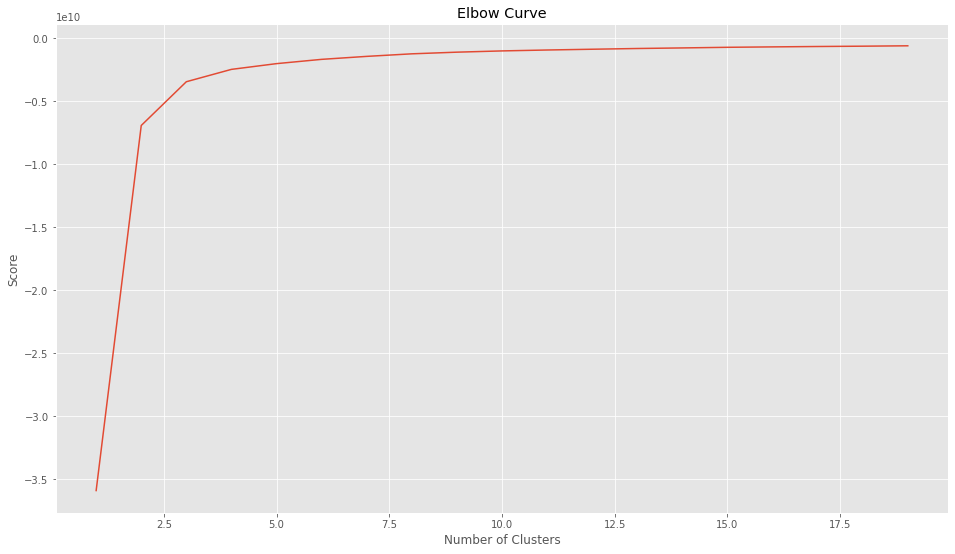

In [87]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(dfcluster).score(dfcluster) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
# Para el ejercicio, elijo 5 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=5).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

In [ ]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X)
# Obtenemos los centroids
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [88]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

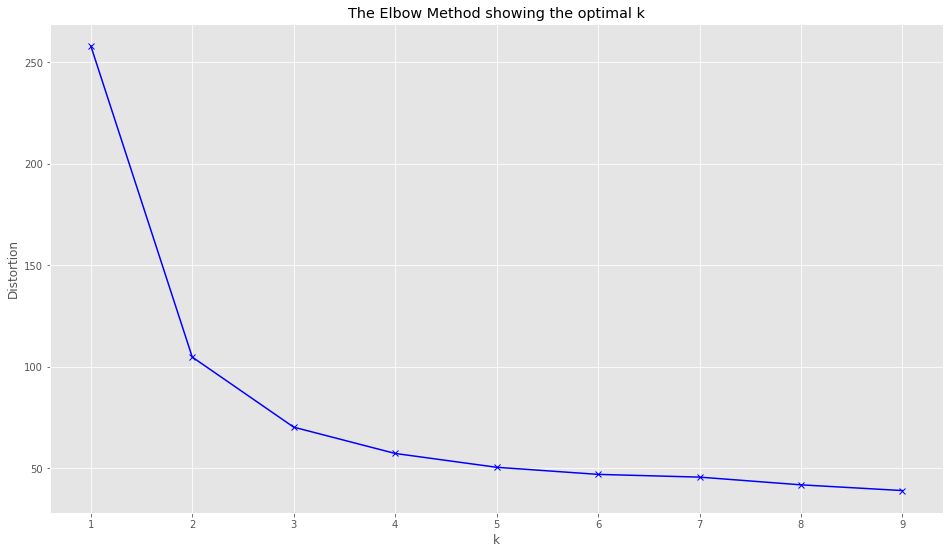

In [89]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(dfcluster)
    kmeanModel.fit(dfcluster)
    distortions.append(sum(np.min(cdist(dfcluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / dfcluster.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [95]:
articles['article_id'] = articles['article_id'].astype(str)
transactions['article_id'] = transactions['article_id'].astype(str)

In [98]:
temp = pd.merge(transactions, articles, on="article_id", how='inner')
temp = pd.merge(temp, customers, on="customer_id", how='inner')
# check null values and drop it.
#display(temp[temp.isnull().any(axis=1)])

#temp = temp.dropna()



#ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_name)

temp

,t_dat,article_id,price,sales_channel_id,previous_visit,days_bw_visits,product_code,prod_name,product_type_no,product_type_name,...,garment_group_no,garment_group_name,detail_desc,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
